In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#!pip3 install subword-nmt --user &> log 
#!wget https://github.com/yandexdataschool/nlp_course/raw/62c1410427385336ef2bea74b09cba39c956207d/week4_seq2seq/data.txt -O data.txt 2> log
#!wget https://github.com/yandexdataschool/nlp_course/raw/62c1410427385336ef2bea74b09cba39c956207d/week4_seq2seq/utils.py -O utils.py 2> log
#!wget https://github.com/yandexdataschool/nlp_course/raw/62c1410427385336ef2bea74b09cba39c956207d/week4_seq2seq/dummy_checkpoint.npz -O dummy_checkpoint.npz 2> log
#thanks to tilda and deephack teams for the data

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12812140760368902882
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7713230029
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15636332935012433868
physical_device_desc: "device: 0, name: Tesla K40m, pci bus id: 0000:02:00.0, compute capability: 3.5"
]


In [4]:
from preprocessing.text_preprocessing import tokenize_corpus
import numpy as np

In [5]:
tokenize_corpus()

In [6]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [7]:
from models.utils import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [8]:
from models.attention_model import *

Using TensorFlow backend.


In [9]:
# WARNING! this cell will clear your TF graph from the regular model. All trained variables will be gone!
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn', inp_voc, out_voc)

D (?, 128)
a (?, ?, 128)
D (?, 128)
a (?, ?, 128)


In [10]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out, out_voc)
train_step = tf.train.AdamOptimizer().minimize(loss)

D (?, 128)
a (?, ?, 128)
D (?, 128)
a (?, ?, 128)
(?, ?)
(?, ?, 7801)


In [11]:
metrics = {'train_loss': [], 'dev_bleu': []}
sess.run(tf.global_variables_initializer())
batch_size = 32

In [12]:
from tqdm import tqdm_notebook, trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

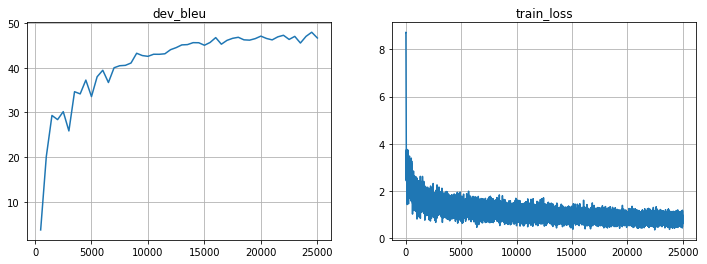

Mean loss=0.813


100%|██████████| 25000/25000 [2:10:48<00:00,  3.19it/s]


In [13]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 500 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out, sess, inp_voc, out_voc)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [14]:
saver = tf.train.Saver()

In [15]:
saver.save(sess, '/srv/hd5/data/vprov/Poems/test_model.ckpt')

'/srv/hd5/data/vprov/Poems/test_model.ckpt'